In [1]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from pymoo.optimize import minimize as moo_minimize
from pymoo.algorithms.moo.nsga3 import ReferenceDirectionSurvival
from pymoode.nsder import NSDER
from pymoode.gde3 import GDE3
from pymoo.factory import get_reference_directions

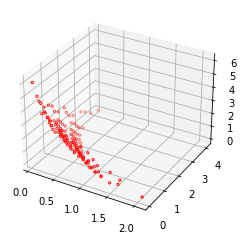

<Axes3DSubplot:>

In [2]:
from pymoo.factory import get_problem
from pymoo.util.plotting import plot

problem = get_problem("wfg1", 10, 3)
plot(problem.pareto_front(), no_fill=True)

In [3]:
lhs = LatinHypercubeSampling()

In [4]:
NGEN = 750
POPSIZE = 136
SEED = 3

In [5]:
problem.__dict__

{'n_var': 10,
 'n_obj': 3,
 'n_constr': 0,
 'data': {'type_var': float},
 'xl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'xu': array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 'callback': None,
 'check_inconsistencies': True,
 'replace_nan_values_by': inf,
 'exclude_from_serialization': [],
 '_pareto_set': <pymoo.util.cache.Cache at 0x1f735e2e9a0>,
 '_pareto_front': <pymoo.util.cache.Cache at 0x1f738f249d0>,
 '_ideal_point': None,
 '_nadir_point': None,
 'S': array([2., 4., 6.]),
 'A': array([1., 1.]),
 'k': 4,
 'l': 6}

In [6]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

In [7]:
ref_dirs.shape

(136, 3)

In [8]:
gde3 = GDE3(pop_size=POPSIZE, CR=0.2, F=(0.1, 1.0), sampling=lhs, gamma=1e-4, refpoint=1,
            variant="DE/ranked/1/bin", SA=0.5,
            survival=ReferenceDirectionSurvival(ref_dirs))

res_gde3 = moo_minimize(problem,
                        gde3,
                        ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  1.054281842 |  0.451357296
    2 |     272 |  1.054218230 |  0.444951966
    3 |     408 |  1.015251349 |  0.434261067
    4 |     544 |  1.001111661 |  0.424338908
    5 |     680 |  0.988102622 |  0.422762426
    6 |     816 |  0.972737992 |  0.416076747
    7 |     952 |  0.972719327 |  0.414355434
    8 |    1088 |  0.972669109 |  0.412678064
    9 |    1224 |  0.905626724 |  0.408278265
   10 |    1360 |  0.905478940 |  0.400678833
   11 |    1496 |  0.902656782 |  0.394192532
   12 |    1632 |  0.873283484 |  0.389142515
   13 |    1768 |  0.873008459 |  0.385430165
   14 |    1904 |  0.871995196 |  0.383157217
   15 |    2040 |  0.847691058 |  0.378027190
   16 |    2176 |  0.839633425 |  0.376484150
   17 |    2312 |  0.839538111 |  0.373518043
   18 |    2448 |  0.839098773 |  0.371896454
   19 |    2584 |  0.832026794 |  0.366863744
   20 |    2720 |  0.817847009 |  0.363614100
   21 |    2856 |  0.784072452 |  

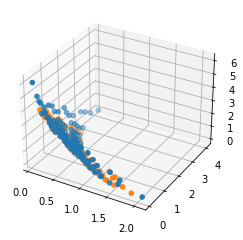

<Axes3DSubplot:>

In [9]:
plot(problem.pareto_front(), res_gde3.F)

In [10]:
nsga3 = NSGA3(pop_size=POPSIZE, sampling=lhs,
              ref_dirs=ref_dirs)

res_nsga3 = moo_minimize(problem,
                         nsga3,
                         ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  1.054281842 |  0.444228534
    2 |     272 |  1.054281842 |  0.438616460
    3 |     408 |  1.054281842 |  0.441095313
    4 |     544 |  1.054150202 |  0.427709026
    5 |     680 |  1.046018042 |  0.424549658
    6 |     816 |  1.040462488 |  0.415242867
    7 |     952 |  1.009651117 |  0.404366308
    8 |    1088 |  1.002187313 |  0.396705171
    9 |    1224 |  0.977020610 |  0.385780819
   10 |    1360 |  0.970073277 |  0.375355190
   11 |    1496 |  0.967453427 |  0.386186336
   12 |    1632 |  0.938052284 |  0.387034254
   13 |    1768 |  0.933881852 |  0.371340181
   14 |    1904 |  0.900730138 |  0.364579902
   15 |    2040 |  0.900693196 |  0.363953988
   16 |    2176 |  0.870008579 |  0.357768751
   17 |    2312 |  0.870008579 |  0.353929484
   18 |    2448 |  0.866647481 |  0.350847895
   19 |    2584 |  0.828916745 |  0.351739258
   20 |    2720 |  0.828940778 |  0.345282123
   21 |    2856 |  0.787300537 |  

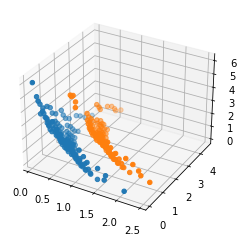

<Axes3DSubplot:>

In [11]:
plot(problem.pareto_front(), res_nsga3.F)

In [12]:
nsder = NSDER(ref_dirs=ref_dirs, pop_size=POPSIZE, CR=0.2, F=(0.1, 1.0), sampling=lhs, gamma=1e-4, refpoint=1.0,
             variant="DE/ranked/1/bin", SA=0.5)
    
res_nsder = moo_minimize(problem,
                         nsder,
                         ('n_gen', NGEN),
                         seed=SEED,
                         save_history=True,
                         verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  1.054281842 |  0.444228534
    2 |     272 |  1.066827094 |  0.441574368
    3 |     408 |  1.034382330 |  0.434556499
    4 |     544 |  1.034239947 |  0.425888297
    5 |     680 |  1.018706891 |  0.419333547
    6 |     816 |  1.018544502 |  0.408972034
    7 |     952 |  1.007075266 |  0.401452082
    8 |    1088 |  0.986201803 |  0.403953435
    9 |    1224 |  0.982085400 |  0.389717168
   10 |    1360 |  0.956146255 |  0.390073579
   11 |    1496 |  0.924199770 |  0.385256013
   12 |    1632 |  0.924199770 |  0.378699216
   13 |    1768 |  0.931099595 |  0.374717952
   14 |    1904 |  0.896782870 |  0.371991023
   15 |    2040 |  0.859797596 |  0.368997378
   16 |    2176 |  0.892964230 |  0.367086900
   17 |    2312 |  0.848584563 |  0.366973774
   18 |    2448 |  0.848170565 |  0.359924439
   19 |    2584 |  0.844306543 |  0.359053543
   20 |    2720 |  0.841794653 |  0.357611454
   21 |    2856 |  0.815449737 |  

%matplotlib qt

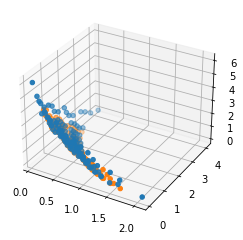

<Axes3DSubplot:>

In [13]:
plot(problem.pareto_front(), res_nsder.F)

In [ ]:
s